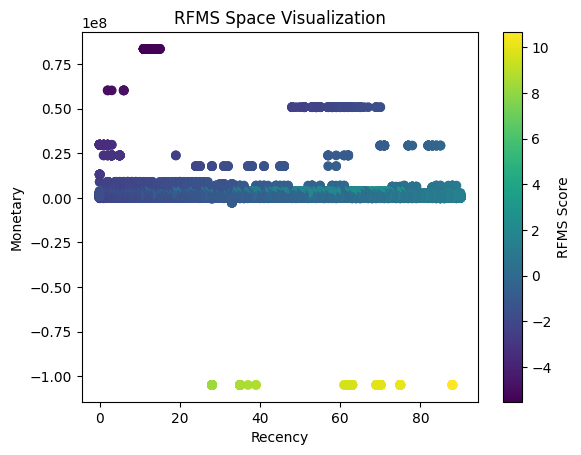

Recency WoE:
                   woe
Recency_Bin          
0.0         -0.510297
1.0         -0.056360
2.0          0.460950
3.0          0.179128
4.0          0.163436

Information Value (IV) for Recency: 0.11209435012364374
Processed data saved to: processed_rfms_data.csv


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import zscore

# Load data

import pandas as pd
df = pd.read_csv('feature_engineered_data.csv')

# 1. Construct RFMS Features
# Recency: Days since last transaction
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
df['Recency'] = (df['TransactionStartTime'].max() - df['TransactionStartTime']).dt.days

# Frequency: Number of transactions per customer
frequency = df.groupby('CustomerId')['TransactionId'].count()
df = df.merge(frequency.rename('Frequency'), on='CustomerId')

# Monetary: Total transaction amount per customer
monetary = df.groupby('CustomerId')['Amount'].sum()
df = df.merge(monetary.rename('Monetary'), on='CustomerId')

# Segment: Initial segmentation based on RFMS score
df['RFMS_Score'] = zscore(df['Recency']) + zscore(df['Frequency']) - zscore(df['Monetary'])

# 2. Visualize RFMS Space
plt.scatter(df['Recency'], df['Monetary'], c=df['RFMS_Score'], cmap='viridis')
plt.colorbar(label='RFMS Score')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('RFMS Space Visualization')
plt.show()

# 3. Assign Good/Bad Labels
threshold = df['RFMS_Score'].median()
df['DefaultLabel'] = np.where(df['RFMS_Score'] > threshold, 'Good', 'Bad')

# 4. Weight of Evidence (WoE) Binning
def calculate_woe_iv(data, feature, target):
    """
    Calculate Weight of Evidence (WoE) and Information Value (IV) for a feature.
    """
    temp = data.groupby(feature)[target].agg(['count', 'sum'])
    temp['good'] = temp['count'] - temp['sum']
    temp['dist_good'] = temp['good'] / temp['good'].sum()
    temp['dist_bad'] = temp['sum'] / temp['sum'].sum()
    temp['woe'] = np.log(temp['dist_good'] / temp['dist_bad'])
    temp['iv'] = (temp['dist_good'] - temp['dist_bad']) * temp['woe']
    iv = temp['iv'].sum()
    return temp[['woe']], iv

# Example: Binning for 'Recency'
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['Recency_Bin'] = discretizer.fit_transform(df[['Recency']])

# Calculate WoE and IV for 'Recency_Bin'
woe_recency, iv_recency = calculate_woe_iv(df, 'Recency_Bin', 'FraudResult')

print("Recency WoE:\n", woe_recency)
print("\nInformation Value (IV) for Recency:", iv_recency)
# Save the processed data for modeling
processed_data_path = "processed_rfms_data.csv"
df.to_csv(processed_data_path, index=False)

print(f"Processed data saved to: {processed_data_path}")